In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#импорт файлов для Андрея
DATA_FOLDER = 'drive/My Drive/Учеба/Methods and models for multivariate data analysis/Course project/'
DATASET_PATH = DATA_FOLDER + 'Dataset/DelayedFlights.csv'

In [ ]:
#импорт файла для Виктора
DATASET_PATH = '/content/drive/MyDrive/Datasets/DelayedFlights.csv'

In [ ]:
!pip install scipy==1.6.2

     |████████████████████████████████| 27.4MB 143kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as st
import statsmodels as sm

matplotlib.rcParams['figure.figsize'] = (12.0, 7.0)
matplotlib.style.use('ggplot')

In [ ]:
scipy.__version__

'1.6.2'

**LAB 1**

by: Victor Voronin (J41321c), Andrey Antonov (J41332c), Nelubin Daniil (J41325c)

## *Step 1* 
Choosing the subsample of our dataset to make further analisys on

In [ ]:
# loading and displaying our dataset
dataset = pd.read_csv(DATASET_PATH)
dataset.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(len(dataset['FlightNum'].unique()))
print(dataset.shape)

7499
(1936758, 30)


In [ ]:
# picking 5 random continious variables
RVs = ['ArrDelay', 'DepDelay', 'TaxiIn', 'TaxiOut', 'ActualElapsedTime']
dataset[RVs].head()

,ArrDelay,DepDelay,TaxiIn,TaxiOut,ActualElapsedTime
0,-14.0,8.0,4.0,8.0,128.0
1,2.0,19.0,5.0,10.0,128.0
2,14.0,8.0,3.0,17.0,96.0
3,34.0,34.0,3.0,10.0,90.0
4,11.0,25.0,4.0,10.0,101.0


## Step 2


Non-parametric estimation of PDF using kernel dencity funtion for continious RVs



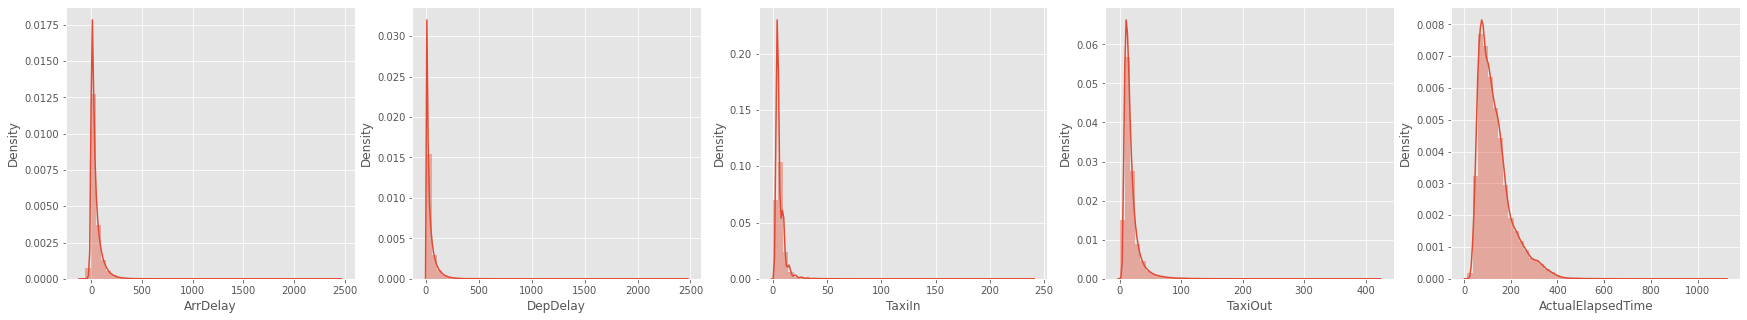

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(30, 5))
for i, key in enumerate(RVs):
  sns.distplot(dataset[key], ax=ax[i], kde=True, norm_hist=True)

## Step 3

An estimation of order statistics and represent them as “box with whiskers” plot.

ArrDelay
Min:	-109.0
Max:	2461.0
Median:	24.0
DepDelay
Min:	6.0
Max:	2467.0
Median:	24.0
TaxiIn
Min:	0.0
Max:	240.0
Median:	6.0
TaxiOut
Min:	0.0
Max:	422.0
Median:	14.0
ActualElapsedTime
Min:	14.0
Max:	1114.0
Median:	116.0


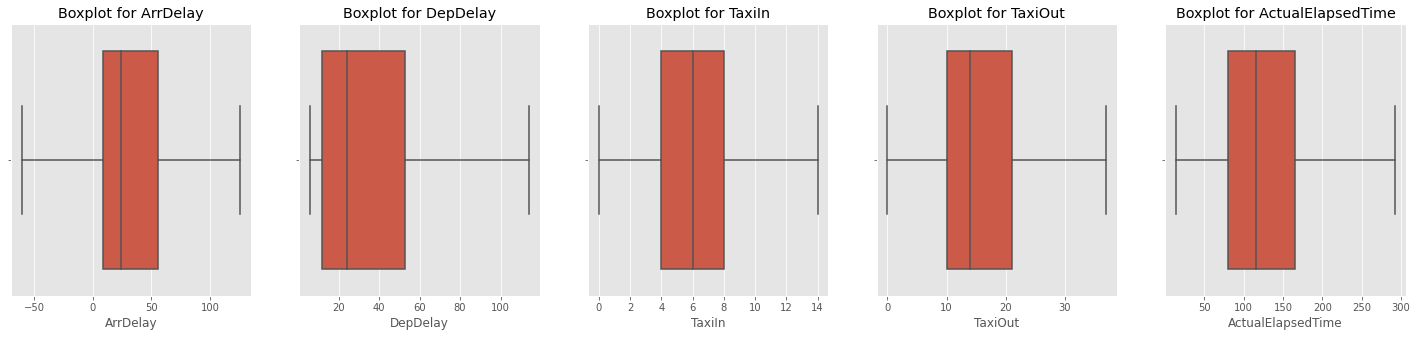

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

for i, key in enumerate(RVs):
  print(key)
  print(f'Min:\t{dataset[key].min()}')
  print(f'Max:\t{dataset[key].max()}')
  print(f'Median:\t{dataset[key].median()}')
  sns.boxplot(ax=ax[i], x=dataset[key], showfliers=False)
  ax[i].set_title(f'Boxplot for {key}')

## Step 4 - 7 

Choosing an apropriate distribution to fit our data

In [ ]:
def get_qq_plot(qn_first, qn_second, distribution, title = ''):
  """create qq-plot"""
  # Calculation of quantiles
  min_qn = np.min([qn_first.min(), qn_second.min()])
  max_qn = np.max([qn_first.max(), qn_second.max()])
  x = np.linspace(0, max_qn*1.25)
  # Building a quantile biplot
  plt.figure(figsize=(8, 8))
  plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
  plt.plot(x, x, color="k", ls="--")
  plt.xlim(0, 300) 
  plt.ylim(0, 300)
  plt.xlabel(f'Empirical distribution')
  plt.ylabel(f'Theoretical ({distribution}) distribution')
  plt.title(title)
  plt.show();

def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    
    y, x = np.histogram(data, bins=bins, density=True, normed = True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.dgamma,st.expon, st.exponnorm, st.gamma, st.laplace,st.levy, 
        st.logistic, st.lognorm, st.norm,st.pareto,st.pearson3,st.powerlaw,
        st.weibull_min
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def get_sample(dist, params, size=10000):
    """Generate sample from given distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.rvs(*params, size)
    pdf = pd.Series(y, x)

    return pdf

def get_data(column_name):
  """delete Nan from initial data"""
  df = dataset[column_name]
  if df.isnull().values.any():
    df = df.dropna()
    print("NaNs were deleted")
  return df

In [ ]:
def ks_test(data, distribution, params, N = 100):
  ks = scipy.stats.kstest(data, distribution, params, N)
  if ks[1] > ks[0]:
    print(f"Kolmogorov test passed. Hypothesis about {distribution} is true")
  else:
    print(f"Kolmogorov test failed. Hypothesis about {distribution} is false")
  print(ks)
def cvm_test(data, distribution, params):
  cvm = st.cramervonmises(data, distribution, params)
  if cvm.pvalue > cvm.statistic: 
    print(f"Cramer-von-mises test passed. Hypothesis about {distribution} is true")
  else:
    print(f"Cramer-von-mises failed. Hypothesis about {distribution} is false")
  print(cvm)

In [ ]:
def pdf_plot(data, sample_mle = None, sample_ls = None, labels = ['original', 'MLE', 'LS'], xlabel = ''):
  fig, ax = plt.subplots()
  for sample in [data, sample_mle, sample_ls]:
      sns.distplot(sample, ax=ax, kde=True, norm_hist=True)
      plt.xlim(-20,500)
      plt.xlabel(xlabel)
      plt.legend(labels)

def trim(data, procentile):
  data_trim = data[data < np.percentile(data, procentile)]
  print(f'There was deleted {data[data > np.percentile(data,procentile)].shape[0]} ({data[data > np.percentile(data,procentile)].shape[0] / data.shape[0] * 100:.1f}%)')
  return data_trim

In [ ]:
def func_exponnorm(x, K):
  return st.exponnorm.pdf(x, K)

def func_gamma(x, a, loc, scale):
  return st.gamma.pdf(x, a, loc, scale)

def func_lognorm(x, s):
  return st.lognorm.pdf(x, s)

##Для 'ArrDelay'

In [ ]:
#mle не работает с пропусками, потому заменяем их
df1 = get_data('ArrDelay')
df1_trim = trim(df1, 99)

NaNs were deleted
There was deleted 19031 (1.0%)


In [ ]:
#выбираем распределение с помощью MLE, расчитываем его параметры 
arrDelay_fit_name, arrDelay_fit_params = best_fit_distribution(df1_trim, 100, ax)
arrDelay_dist = getattr(st, arrDelay_fit_name)
print("The best distribution for arrDelay ", arrDelay_fit_name)

The best distribution for arrDelay  exponnorm


In [ ]:
#рассчитываем квантили наблюдаемого и теоретического по mle
percs = np.linspace(0, 100, 100)
qn_first = np.percentile(df1_trim, percs)

sample_mle = get_sample(arrDelay_dist, arrDelay_fit_params, size = df1_trim.shape[0])
qn_second = np.percentile(sample_mle, percs)

In [ ]:
#определяем параметры теоретического распределения с помощью LS


x = np.linspace(0,100,100)
popt, pcov = scipy.optimize.curve_fit(func_exponnorm, xdata=x, ydata=np.percentile(df1_trim, x))

#генерируем распределение с полученными параметрами и вычисляем квантили
sample_ls = st.exponnorm.rvs(*popt, size = df1_trim.shape[0])
qn_third = np.percentile(sample_ls, percs)

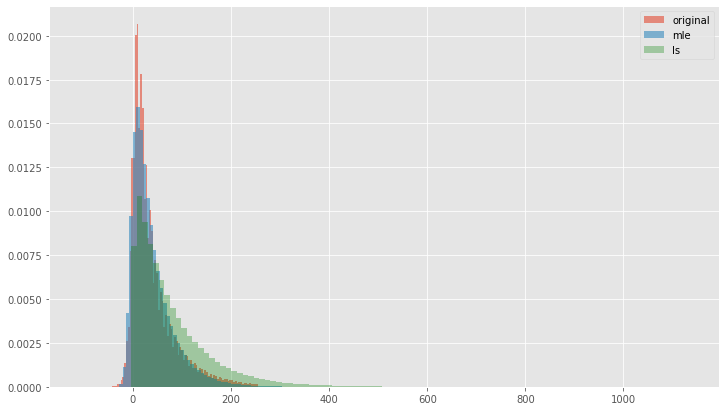

In [ ]:
plt.hist(df1_trim, bins = 100, alpha = 0.6, density = True, label = 'original')
plt.hist(sample_mle, bins = 100, alpha = 0.6, density = True, label = 'mle')
plt.hist(sample_ls, bins = 100, density = True, alpha = 0.3, label = 'ls', color = 'green')
plt.legend()
plt.show();

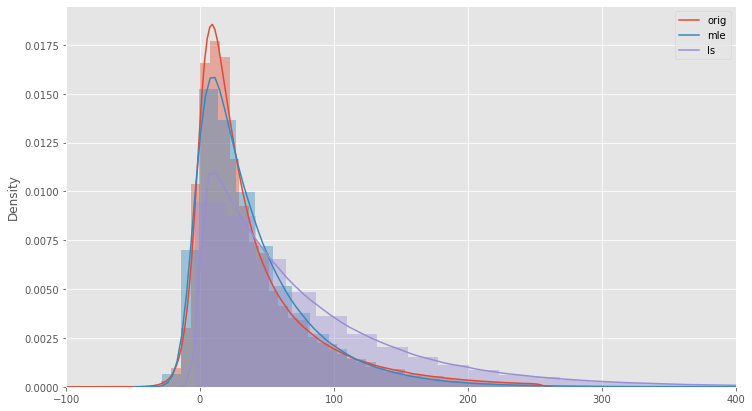

In [ ]:
#строим графики всех трех распределений
pdf_plot(df1_trim, sample_mle, sample_ls, labels = ['orig', 'mle', 'ls'])

Kolmogorov test passed. Hypothesis about exponnorm is true
KstestResult(statistic=0.04499305436138945, pvalue=0.9819824862817212)
Cramer-von-mises test passed. Hypothesis about exponnorm is true
CramerVonMisesResult(statistic=0.0419013600982592, pvalue=0.9240312451489583)


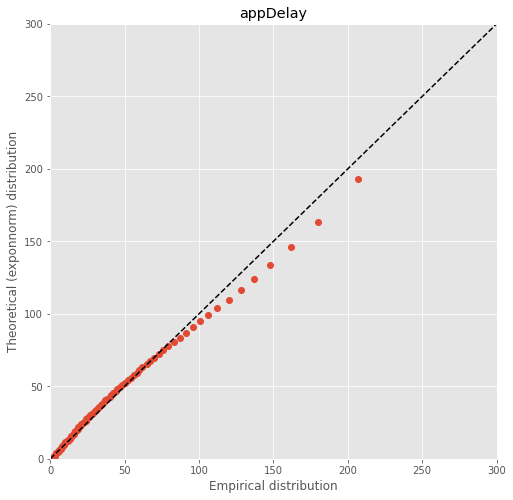

In [ ]:
#выполняем статистические тесты
ks_test(qn_first, arrDelay_fit_name, arrDelay_fit_params, N = 100)
cvm_test(qn_first, arrDelay_fit_name, arrDelay_fit_params)

#строим  QQ-plot
get_qq_plot(qn_first, qn_second, arrDelay_fit_name, title = 'appDelay')

##Для DepDelay

In [ ]:
df2 = get_data('DepDelay')
df2_trim = trim(df2, 99)

There was deleted 19285 (1.0%)


In [ ]:
#выбираем распределение с помощью MLE, расчитываем его параметры 
depDelay_fit_name, depDelay_fit_params = best_fit_distribution(df2_trim, 1000, ax)
depDelay_dist = getattr(st, depDelay_fit_name)
print("The best distribution for depDelay ", depDelay_fit_name)

In [ ]:
#рассчитываем квантили наблюдаемого и теоретического по mle
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(df2_trim, percs)

sample_mle = get_sample(depDelay_dist, depDelay_fit_params, size = df2_trim.shape[0])
qn_second = np.percentile(sample_mle, percs)

In [ ]:
#определяем параметры теоретического распределения с помощью LS

  
x = np.linspace(0,100,100)
popt, pcov = scipy.optimize.curve_fit(func_gamma, xdata=x, ydata=np.percentile(df2_trim, x))
#генерируем распределение с полученными параметрами и вычисляем квантили
sample_ls = scipy.stats.gamma.rvs(*depDelay_fit_params, size = df2_trim.shape[0])
qn_third = np.percentile(sample_ls, percs)

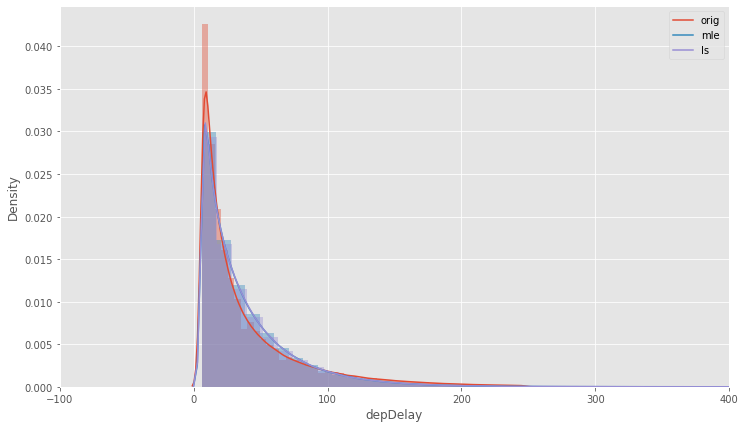

In [ ]:
pdf_plot(df2_trim, sample_mle, sample_ls, labels = ['orig', 'mle', 'ls'], xlabel='depDelay')

Kolmogorov test passed. Hypothesis about gamma is true
KstestResult(statistic=0.08444320070857567, pvalue=0.9951386904565588)
Cramer-von-mises test passed. Hypothesis about gamma is true
CramerVonMisesResult(statistic=0.03560463765719529, pvalue=0.9578994329529466)


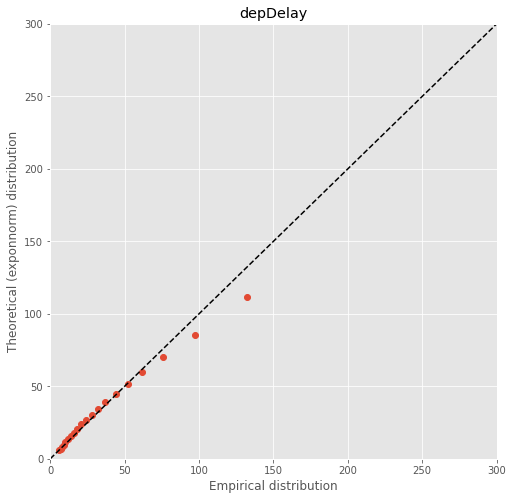

In [ ]:
#выполняем статистические тесты
ks_test(qn_first, depDelay_fit_name, depDelay_fit_params)
cvm_test(qn_first, depDelay_fit_name, depDelay_fit_params)

#строим  QQ-plot
get_qq_plot(qn_first, qn_second, arrDelay_fit_name, title = 'depDelay')

##Для TaxiIn

In [ ]:
df3 = get_data('TaxiIn')

NaNs were deleted
There was deleted 0 (0.0%)


In [ ]:
params_test = scipy.stats.exponnorm.fit(df3_trim)

In [ ]:
#общая логика работы
#обрезали все, что выше 99 квантиля. подобрали параметры распределения. прошли кс-тест 
count, bins = np.histogram(df3_trim, bins = 100, normed = True, density = True)
#params_test = scipy.stats.exponnorm.fit(count)
percs_test = np.linspace(0, 100, 21)
qn_first_test = np.percentile(df3_trim, percs_test)

print(scipy.stats.kstest(qn_first_test, 'exponnorm', params_test))

taxiIn_dist_test = getattr(st, 'exponnorm')
sample_mle_test = get_sample(taxiIn_dist_test, params_test, size = df3_trim.shape[0])

KstestResult(statistic=0.09729924669289036, pvalue=0.9772347732604307)


In [ ]:
#выбираем распределение с помощью MLE, расчитываем его параметры 
taxiIn_fit_name, taxiIn_fit_params = best_fit_distribution(df3_trim, 1000, ax)
taxiIn_dist = getattr(st, taxiIn_fit_name)
print("The best distribution for arrDelay ", taxiIn_fit_name)

The best distribution for arrDelay  exponnorm


In [ ]:
#рассчитываем квантили наблюдаемого и теоретического по mle
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(df3_trim, percs)

sample_mle = get_sample(taxiIn_dist, taxiIn_fit_params, size = df3_trim.shape[0])
qn_second = np.percentile(sample_mse, percs)

In [ ]:
#определяем параметры теоретического распределения с помощью LS

x = np.linspace(0,100,100)
popt, pcov = scipy.optimize.curve_fit(func_exponnorm, xdata=x, ydata=np.percentile(df3_trim, x))

#генерируем распределение с полученными параметрами и вычисляем квантили
sample_ls = st.exponnorm.rvs(*popt, size = df3_trim.shape[0])
qn_third = np.percentile(sample_ls, percs)

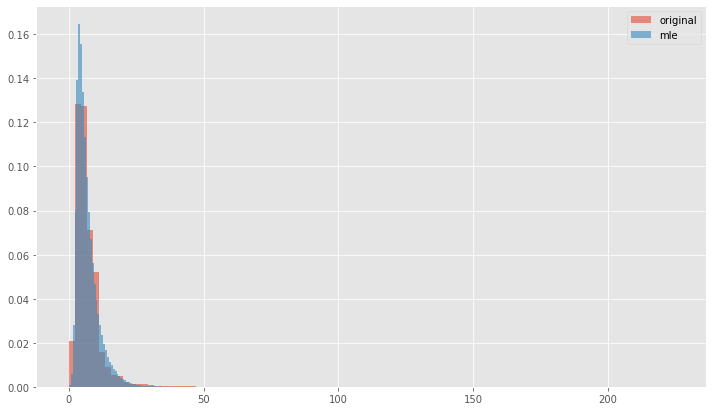

In [ ]:
plt.hist(df3_trim, bins = 100, alpha = 0.6, density = True, label = 'original')
plt.hist(sample_mle, bins = 100, alpha = 0.6, density = True, label = 'mle')
#plt.hist(sample_ls, bins = 100, density = True, alpha = 0.3, label = 'ls', color = 'green')
plt.legend()
plt.show();

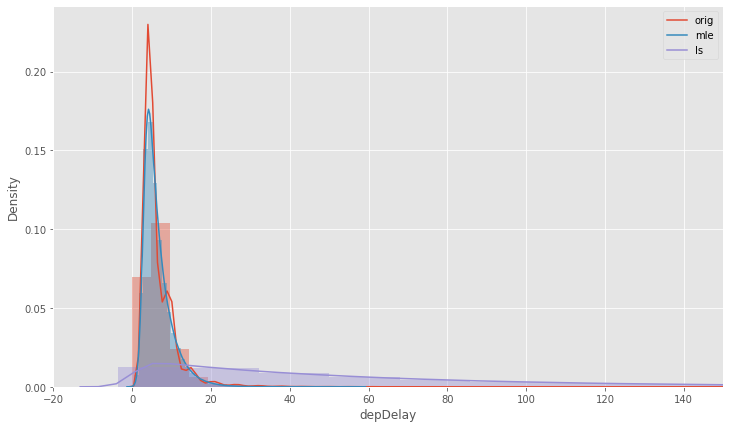

In [ ]:
pdf_plot(df3, sample_mse, sample_ls, labels = ['orig', 'mle', 'ls'], xlabel='depDelay')

Kolmogorov test passed. Hypothesis about exponnorm is true
KstestResult(statistic=0.09015921405723515, pvalue=0.9894732944594594)
Cramer-von-mises test passed. Hypothesis about exponnorm is true
CramerVonMisesResult(statistic=0.02830788767065477, pvalue=0.9836211576696864)


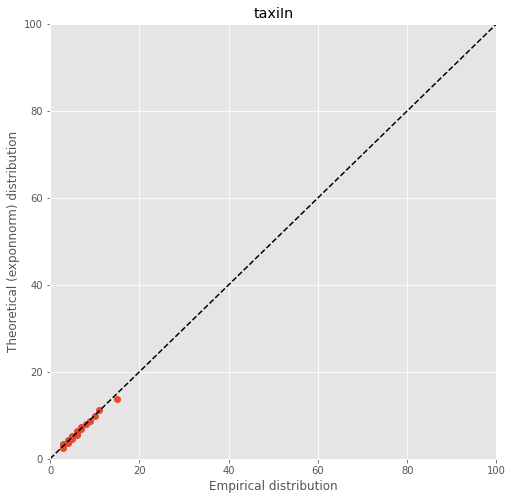

In [ ]:
#выполняем статистические тесты
ks_test(qn_first, taxiIn_fit_name, taxiIn_fit_params)
cvm_test(qn_first, taxiIn_fit_name, taxiIn_fit_params)

#строим  QQ-plot
get_qq_plot(qn_first, qn_second, taxiIn_fit_name, title = 'taxiIn')

##Для TaxiOut

In [ ]:
df4 = get_data('TaxiOut')

NaNs were deleted
There was deleted 0 (0.0%)


In [ ]:
#выбираем распределение с помощью MLE, расчитываем его параметры 
taxiOut_fit_name, taxiOut_fit_params = best_fit_distribution(df4, 100, ax)
taxiOut_dist = getattr(st, taxiOut_fit_name)
print("The best distribution for arrDelay ", taxiOut_fit_name)

The best distribution for arrDelay  exponnorm


In [ ]:
#рассчитываем квантили наблюдаемого и теоретического по mle
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(df4, percs)

sample_mle = get_sample(taxiOut_dist, taxiOut_fit_params, size = df4.shape[0])
qn_second = np.percentile(sample_mle, percs)

In [ ]:
#определяем параметры теоретического распределения с помощью LS

x = np.linspace(0,100,100)
popt, pcov = scipy.optimize.curve_fit(func_exponnorm, xdata=x, ydata=np.percentile(df4, x))

#генерируем распределение с полученными параметрами и вычисляем квантили
sample_ls = scipy.stats.exponnorm.rvs(*popt, size = df4.shape[0])
qn_third = np.percentile(sample_ls, percs)

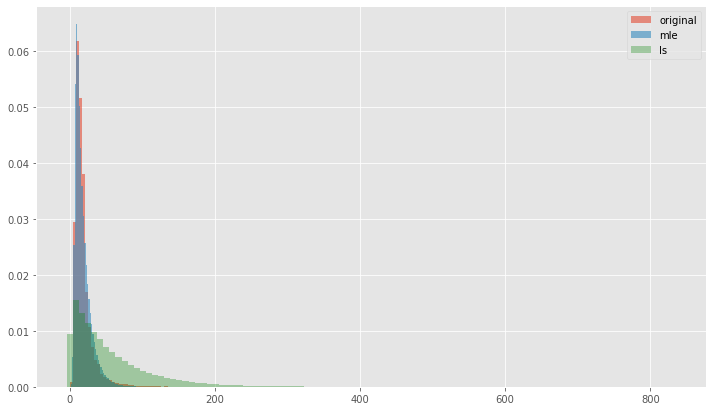

In [ ]:
plt.hist(df4, bins = 100, alpha = 0.6, density = True, label = 'original')
plt.hist(sample_mle, bins = 100, alpha = 0.6, density = True, label = 'mle')
plt.hist(sample_ls, bins = 100, density = True, alpha = 0.3, label = 'ls', color = 'green')
plt.legend()
plt.show();

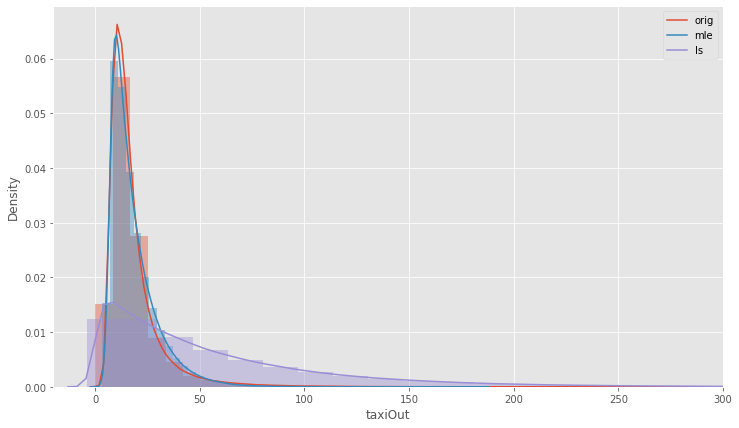

In [ ]:
#строим графики всех трех распределений
pdf_plot(df4, sample_mle, sample_ls, labels = ['orig', 'mle', 'ls'], xlabel='taxiOut')

Kolmogorov test passed. Hypothesis about exponnorm is true
KstestResult(statistic=0.07373756374669216, pvalue=0.9993159525296)
Cramer-von-mises test passed. Hypothesis about exponnorm is true
CramerVonMisesResult(statistic=0.021320717913305785, pvalue=0.9964934842550731)


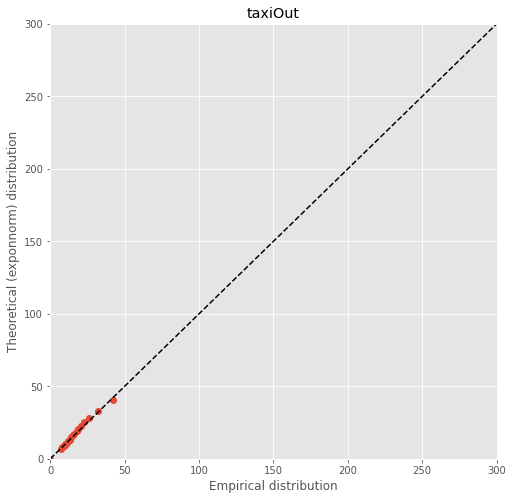

In [ ]:
#выполняем статистические тесты
ks_test(qn_first, taxiOut_fit_name, taxiOut_fit_params)
cvm_test(qn_first, taxiOut_fit_name, taxiOut_fit_params)

#строим  QQ-plot
get_qq_plot(qn_first, qn_second, taxiOut_fit_name, title = 'taxiOut')

##Для ActualElapsedTime

In [ ]:
df5 = get_data('ActualElapsedTime')
df5_trim = trim(df5, 99)

NaNs were deleted
There was deleted 19158 (1.0%)


In [ ]:
#выбираем распределение с помощью MLE, расчитываем его параметры 
actualTime_fit_name, actualTime_fit_params = best_fit_distribution(df5, 100, ax)
actualTime_dist = getattr(st, actualTime_fit_name)
print("The best distribution for arrDelay ", actualTime_fit_name)

The best distribution for arrDelay  lognorm


In [ ]:
#рассчитываем квантили наблюдаемого и теоретического по mle
percs = np.linspace(0, 100, 100)
qn_first = np.percentile(df5_trim, percs)

sample_mle = get_sample(actualTime_dist, actualTime_fit_params, size = df5_trim.shape[0])
qn_second = np.percentile(sample_mle, percs)

In [ ]:
actualTime_fit_params

(0.577553821682016, 12.770008398186263, 102.30554654920272)

In [ ]:
#определяем параметры теоретического распределения с помощью LS

x = np.linspace(0, 100, 100)
popt, pcov = scipy.optimize.curve_fit(func_lognorm, xdata=x, ydata=np.percentile(df5_trim, x))

#генерируем распределение с полученными параметрами и вычисляем квантили
sample_ls = scipy.stats.lognorm.rvs(*popt, size = df5_trim.shape[0])
qn_third = np.percentile(sample_ls, percs)

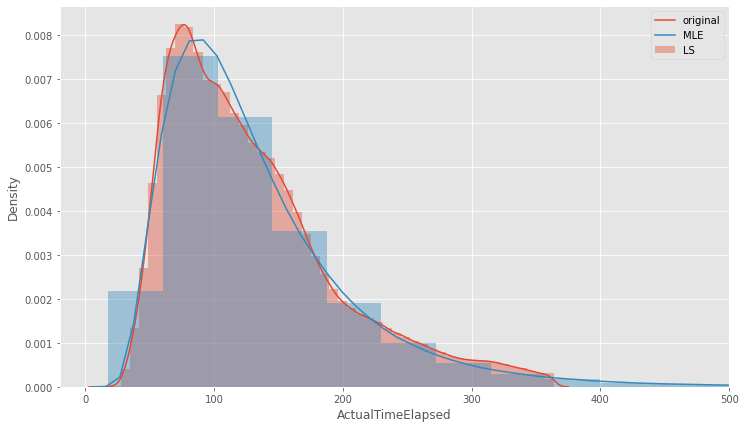

In [ ]:
pdf_plot(df5_trim, sample_mle, xlabel = 'ActualTimeElapsed',)

Kolmogorov test passed. Hypothesis about lognorm is true
KstestResult(statistic=0.028464329251796594, pvalue=0.9999913705874018)
Cramer-von-mises test passed. Hypothesis about lognorm is true
CramerVonMisesResult(statistic=0.009865360197626807, pvalue=0.9999959937041715)


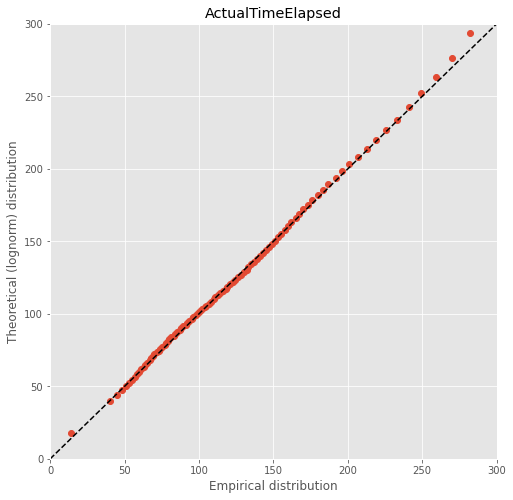

In [ ]:
#выполняем статистические тесты
ks_test(qn_first, actualTime_fit_name, actualTime_fit_params,)
cvm_test(qn_first, actualTime_fit_name, actualTime_fit_params)

#строим  QQ-plot
get_qq_plot(qn_first, qn_second, actualTime_fit_name, title = 'ActualTimeElapsed')

#GMM

это проба пера на смесях. Черновик

In [ ]:
from sklearn import mixture

def best_gmm(X):
  lowest_bic = np.infty
  bic = []
  n_components_range = range(1, 3)
  cv_types = ['spherical', 'tied', 'diag', 'full']
  for cv_type in cv_types:
      for n_components in n_components_range:
          # Fit a Gaussian mixture with EM
          gmm = mixture.GaussianMixture(n_components=n_components,
                                        covariance_type=cv_type)
          gmm.fit(X)
          bic.append(gmm.bic(X))
          if bic[-1] < lowest_bic:
              lowest_bic = bic[-1]
              best_gmm = gmm
  return best_gmm

In [ ]:
test_df = np.zeros([len(df1),2])
test_df[:, 0] = np.copy(df1)
clf = best_gmm(test_df)

In [ ]:
clf

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
test_df[:,1] = clf.predict(test_df)
np.unique(test_df[:,1])

array([0., 1.])

In [ ]:
clf.weights_[0]

0.7560334241684203

In [ ]:
a1, a2 = [test_df[test_df[:,1] == i] for i in np.unique(test_df[:,1])]

In [ ]:
a1_fit_name, a1_fit_params = best_fit_distribution(a1, 100, ax)
a1_dist = getattr(st, a1_fit_name)
print("The best distribution for a1 ", a1_fit_name)

The best distribution for a1  dgamma


In [ ]:
a2_fit_name, a2_fit_params = best_fit_distribution(a2, 100, ax)
a2_dist = getattr(st, a2_fit_name)
print("The best distribution for a2 ", a2_fit_name)

The best distribution for a2  gamma


In [ ]:
percs = np.linspace(0, 100, 21)

sample_mse_a1 = get_sample(a1_dist, a1_fit_params, size = round(len(df1) * clf.weights_[0]))
qn_second_a1 = np.percentile(sample_mse_a1, percs)

sample_mse_a2 = get_sample(a2_dist, a2_fit_params, size = round(len(df1) * clf.weights_[1]))
qn_second_a2 = np.percentile(sample_mse_a2, percs)

In [ ]:
print(len(sample_mse_a1) / len(df1), len(sample_mse_a2) / len(df1))
print(len(sample_mse_a1) + len(sample_mse_a2))
print(len(df1))

0.7560334603662885 0.24396653963371157
1928371
1928371


In [ ]:
sample_test = np.concatenate((sample_mse_a1, sample_mse_a2))
len(sample_test)

1928371

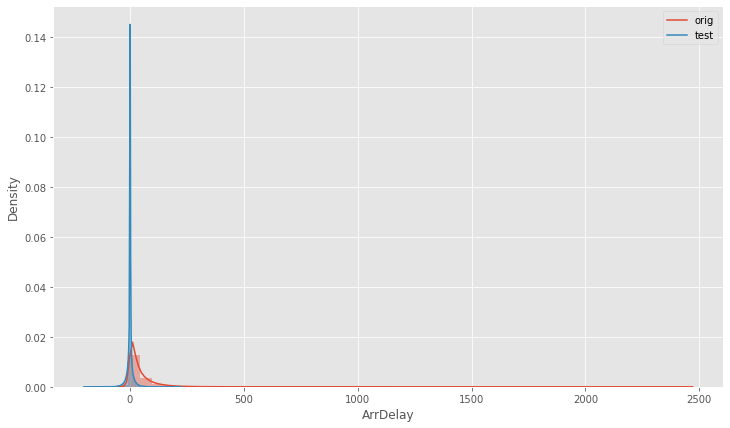

In [ ]:
pdf_plot(df1, sample_test, labels = ['orig', 'test'])

In [ ]:
ks_test(df1, 'laplace', a1_fit_params)
print()
ks_test(qn_second_a2, 'exponnorm', a2_fit_params)

Kolmogorov test passed. Hypothesis about laplace is true
KstestResult(statistic=0.010031523780449247, pvalue=1.0)

Kolmogorov test passed. Hypothesis about exponnorm is true
KstestResult(statistic=0.010376596405907018, pvalue=1.0)


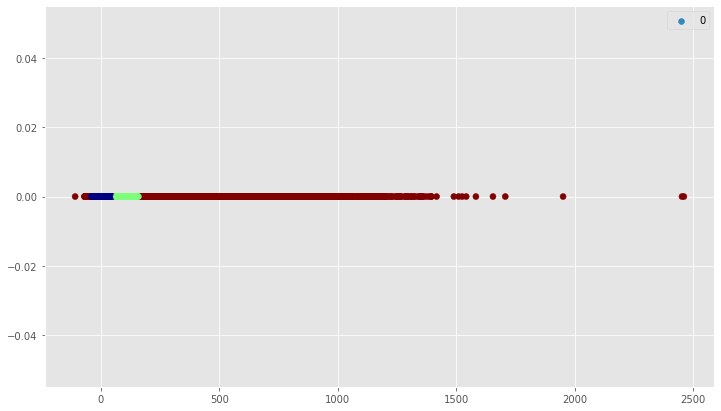

In [ ]:
labels = ['0','1','2']
plt.scatter(x = test_df[:,0], y = np.zeros([len(test_df)]),c = test_df[:,1], cmap='jet')
plt.legend(labels)
plt.show();

In [ ]:
# Combining all PDF files into one dataset:
pdf_data = [np_pdf_01, np_pdf_02, np_pdf_03, np_pdf_04, np_pdf_05]
pdf_dataframe_ini = pd.DataFrame(pdf_data)
pdf_dataframe = pd.DataFrame.transpose(pdf_dataframe_ini)

# Creating one PDF from the PDF dataset:
gmm = GMM(n_components=1)
gmm.fit(pdf_dataframe)
x_pdf_data = [x_axis_pdf_01, x_axis_pdf_02, x_axis_pdf_03, x_axis_pdf_04, x_axis_pdf_05]
x_pdf = average(x_pdf_data)
x_pdf = list(x_pdf)
x = np.linspace(np.min(x_pdf), np.max(x_pdf), len(x_pdf)).reshape(len(x_pdf), 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)

In [ ]:
RVs

['ArrDelay', 'DepDelay', 'TaxiIn', 'TaxiOut', 'ActualElapsedTime']

(1928371,)
(1909068,)


KstestResult(statistic=0.06382788389486094, pvalue=0.9999953185406877)

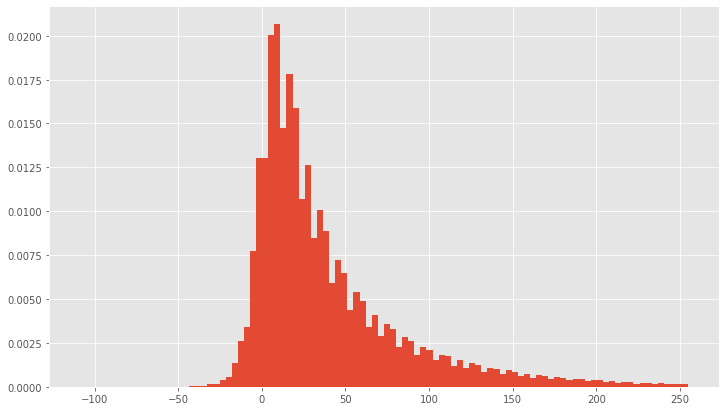

In [ ]:
#общая логика работы
#обрезали все, что выше 99 квантиля. подобрали параметры распределения. прошли кс-тест 
print(df_test.shape)
df_trim = df_test[df_test < np.percentile(df_test,99)]
print(df_trim.shape)
count, bins, ignored = plt.hist(df_trim, bins = 100, density = True)
params = scipy.stats.exponnorm.fit(df_trim)
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(df_trim, percs)
scipy.stats.kstest(qn_first, 'exponnorm', params)